# <font color=dodgerblue> Notebook options </font>

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <font color=dodgerblue> Imports </font>

In [3]:
# importing standard libraries
import os
import json
import pandas as pd
import uuid
import ibis

# <font color=dodgerblue> Create Connection </font>

In [68]:
con = ibis.duckdb.connect("test_db.ddb")

# <font color=dodgerblue> Import Data </font>

## <font color=orange> Customer Data </font>

In [65]:
customer_data = con.read_csv(
    '../data/01_raw/customer_data.csv',
    table_name='customer_data',
    
)
customer_data.head().execute()

,Customer ID,Grade,Sub Grade,Employment Length,Home Ownership,Annual Income,Loan Status,Payment Plan
0,1,A,A1,1.0,MORTGAGE,34000.0,Fully Paid,n
1,2,A,A1,1.0,MORTGAGE,36000.0,Fully Paid,n
2,3,A,A1,1.0,MORTGAGE,42000.0,Charged Off,n
3,4,A,A1,1.0,MORTGAGE,49000.0,Fully Paid,n
4,5,A,A1,1.0,MORTGAGE,50000.0,Fully Paid,n


## <font color=orange> Product Data </font>

In [66]:
product_data = con.read_csv('../data/01_raw/product_data.csv', table_name='product_data')
product_data.head().execute()

,Customer ID,Product,Take Up,Value
0,6,Car,True,5926.968276
1,11,Car,False,12939.951513
2,17,Car,False,39558.648292
3,34,Car,False,86960.194717
4,40,Car,False,39107.895244


## <font color=dodgerblue> Preprocessing </font>

## <font color=orange> Product </font>

In [9]:
from SmartLeads.pipelines.preprocessing.nodes import get_products_table
con.create_table('products_table', get_products_table(product_data), overwrite=True)
products_table = con.table('products_table')
products_table.head().execute()

,Product
0,Debt Consolidation
1,Home Improvement
2,Car
3,Credit Card


In [10]:
from SmartLeads.pipelines.preprocessing.nodes import preprocess_product_data
product_data_preprocessed, product_data_pipe = preprocess_product_data(product_data, products_table)
con.create_table('product_data_preprocessed', product_data_preprocessed, overwrite=True)
product_data_preprocessed = con.table('product_data_preprocessed')
product_data_preprocessed.head().execute()

,Customer ID,P~Debt Consolidation,P~Home Improvement,P~Car,P~Credit Card
0,6338,Debt Consolidation,,,
1,5542,Debt Consolidation,,,
2,5969,Debt Consolidation,,,
3,806,Debt Consolidation,,,Credit Card
4,2520,Debt Consolidation,,,Credit Card


## <font color=orange> Customer </font>

In [11]:
from SmartLeads.pipelines.preprocessing.nodes import preprocess_customer_data
customer_data_preprocessed, customer_data_pipe = preprocess_customer_data(customer_data)
con.create_table('customer_data_preprocessed', customer_data_preprocessed, overwrite=True)
customer_data_preprocessed = con.table('customer_data_preprocessed')
customer_data_preprocessed.head().execute()


,Customer ID,Grade,Sub Grade,Employment Length,Home Ownership,Annual Income,Loan Status,Payment Plan
0,1,A,A1,"(-inf, 1.00]",MORTGAGE,"(-inf, 34 000]",Fully Paid,n
1,2,A,A1,"(-inf, 1.00]",MORTGAGE,"[34 000, 42 000]",Fully Paid,n
2,3,A,A1,"(-inf, 1.00]",MORTGAGE,"[34 000, 42 000]",Charged Off,n
3,4,A,A1,"(-inf, 1.00]",MORTGAGE,"[42 000, 49 919]",Fully Paid,n
4,5,A,A1,"(-inf, 1.00]",MORTGAGE,"[49 919, 56 000]",Fully Paid,n


## <font color=orange> Combine </font>

In [12]:
from SmartLeads.pipelines.preprocessing.nodes import combine_customer_and_product_data
combined = combine_customer_and_product_data(customer_data_preprocessed, product_data_preprocessed)
con.create_table('combined', combined, overwrite=True)
combined = con.table('combined')
combined.head().execute()

,Customer ID,Grade,Sub Grade,Employment Length,Home Ownership,Annual Income,Loan Status,Payment Plan,P~Debt Consolidation,P~Home Improvement,P~Car,P~Credit Card
0,1,A,A1,"(-inf, 1.00]",MORTGAGE,"(-inf, 34 000]",Fully Paid,n,Debt Consolidation,,,
1,2,A,A1,"(-inf, 1.00]",MORTGAGE,"[34 000, 42 000]",Fully Paid,n,Debt Consolidation,Home Improvement,,
2,3,A,A1,"(-inf, 1.00]",MORTGAGE,"[34 000, 42 000]",Charged Off,n,Debt Consolidation,Home Improvement,,Credit Card
3,4,A,A1,"(-inf, 1.00]",MORTGAGE,"[42 000, 49 919]",Fully Paid,n,Debt Consolidation,Home Improvement,,
4,5,A,A1,"(-inf, 1.00]",MORTGAGE,"[49 919, 56 000]",Fully Paid,n,Debt Consolidation,Home Improvement,,


# <font color=dodgerblue> Create Model </font>

## <font color=orange> Combine customers into model points </font>

In [51]:
from SmartLeads.pipelines.create_model.nodes import get_combined_grouped
combined_grouped = get_combined_grouped(combined)
con.create_table('combined_grouped', combined_grouped, overwrite=True)
combined_grouped = con.table('combined_grouped')
combined_grouped.head().execute()

,Grade,Sub Grade,Employment Length,Home Ownership,Annual Income,Loan Status,Payment Plan,P~Debt Consolidation,P~Home Improvement,P~Car,P~Credit Card,row_freq
0,A,A1,"(-inf, 1.00]",MORTGAGE,"[34 000, 42 000]",Fully Paid,n,Debt Consolidation,Home Improvement,,,1
1,A,A1,"(-inf, 1.00]",MORTGAGE,"[65 000, 75 000]",Fully Paid,n,Debt Consolidation,,,Credit Card,2
2,A,A1,"(-inf, 1.00]",MORTGAGE,"[100 000, 135 000]",Current,n,Debt Consolidation,Home Improvement,,,1
3,A,A1,"[1.00, 2.00]",MORTGAGE,"[34 000, 42 000]",Fully Paid,n,,Home Improvement,,,1
4,A,A1,"[1.00, 2.00]",MORTGAGE,"[100 000, 135 000]",Fully Paid,n,Debt Consolidation,Home Improvement,,,2


## <font color=orange> Create Associations </font>

In [60]:
from SmartLeads.pipelines.create_model.nodes import get_combo_frequency_counts

min_features_per_rule = 1
max_features_per_rule = 2
min_confidence = 0.25

combos = get_combo_frequency_counts(
    con,
    combined_grouped,
    min_features_per_rule,
    max_features_per_rule,
    min_confidence
)
con.create_table('combos', combos, overwrite=True)
combos = con.table('combos')
combos.head().execute()

Number of features per rule: 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


,Grade,a_freq,Sub Grade,Employment Length,Home Ownership,Annual Income,Loan Status,Payment Plan,P~Debt Consolidation,P~Home Improvement,P~Car,P~Credit Card,num_features,a_and_b_freq,Recommendation,product_support,confidence,lift
0,A,2896,,,,,,,,,,,1,1224,P~Credit Card,0.432174,0.422652,0.977967
1,B,5874,,,,,,,,,,,1,2898,P~Credit Card,0.432174,0.493361,1.141579
2,C,4151,,,,,,,,,,,1,1897,P~Credit Card,0.432174,0.456998,1.057441
3,D,2512,,,,,,,,,,,1,1580,P~Credit Card,0.432174,0.628981,1.455388
4,E,1135,,,,,,,,,,,1,353,P~Credit Card,0.432174,0.311013,0.719648


## <font color=orange> Clear temp tables </font>

In [2]:
from SmartLeads.pipelines.create_model.nodes import clear_temp_tables
clear_temp_tables(con)

NameError: name 'con' is not defined

In [61]:
df = combos.execute()

<Axes: >

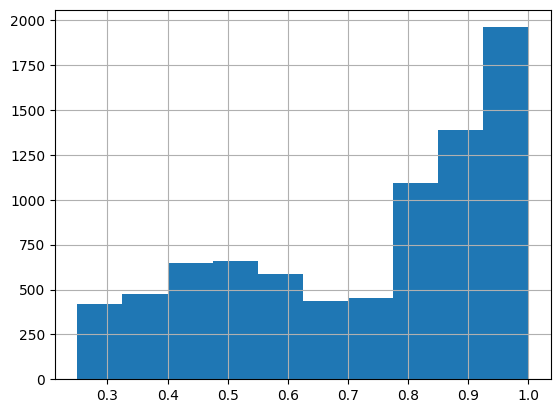

In [62]:
df['confidence'].hist()

<Axes: >

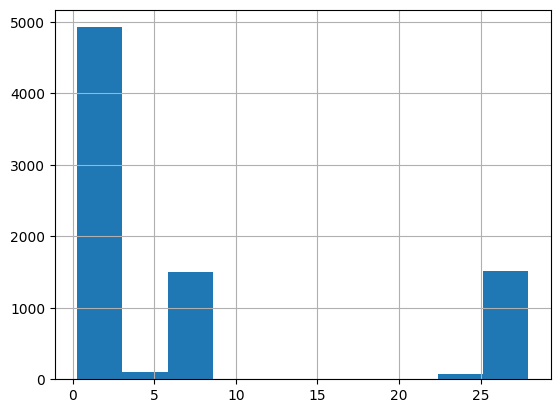

In [64]:
df['lift'].hist()